## Notebook for 1D BDT scan and calculating FOMs in Bd2psi2SKS on data


In [99]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/chasenberg/repos/')
import os
import sys
import ROOT
from ROOT import TFile, TH1D, TH2D, TCanvas, gStyle, TLine, TTree
from ROOT import (RooArgSet, RooRealVar, RooDataSet, RooPlot, RooFit, RooStats, RooArgList)
import root_pandas as rp
import root_numpy as ry 

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd

sys.path.append('/home/vmueller/repos')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls
from dopy.doplot.plotting import Plotter, Plot                

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

### Read ROOT file

In [101]:
dataset_file_name = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/wrong_pv/Bd2JpsimumuKS_mc_2015_2016_selected.root'

In [102]:
branches = [
            'B0_TAGOMEGA_OS',
            'B0_TAGDECISION_OS',
            'B0_TAU',
            'B0_TAUERR',
            'Delta_TAU',
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            'idxRunNumber',
            'idxEventNumber'
            ]

In [103]:
tree_mc = 'Bd2JpsiKs'
signal_dataframe_wrongPV  = rp.read_root(dataset_file_name,key=tree_mc,columns=branches,where='', flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [104]:
#signal_dataframe_wrongPV['B0_TAUERR'] = signal_dataframe_wrongPV['Delta_TAU']

In [105]:
'''test_1 = pd.DataFrame()
test_2 = pd.DataFrame()
test_3 = pd.DataFrame()
for row in signal_dataframe_wrongPV.itertuples():
    print("yes")
pv_num = signal_dataframe_wrongPV['runNumber'].unique()
pv_num = np.array(pv_num)
print(len(pv_num))
for nums in pv_num:
    num = str(nums)
    test_1 = signal_dataframe_wrongPV.query('runNumber'+'=='+num)
    evt_num = test_1['eventNumber'].unique()
    evt_num = np.array(evt_num)
    print(len(evt_num))
    for evts in evt_num:
        print(len(evt_num))
        evt = str(evts)
        #print(test_1.query('eventNumber'+'=='+evt).shape).sample(n=1)
        test_3.append(test_1[test_1['eventNumber']==evts]).sample(n=1) 
    for evts in evt_num:
        print(len(evt_num))
        evt = str(evts)
        #print(test_1.query('eventNumber'+'=='+evt).shape).sample(n=1)
        test_3.append(test_1[test_1['eventNumber']==evts]).sample(n=1)'''

'test_1 = pd.DataFrame()\ntest_2 = pd.DataFrame()\ntest_3 = pd.DataFrame()\nfor row in signal_dataframe_wrongPV.itertuples():\n    print("yes")\npv_num = signal_dataframe_wrongPV[\'runNumber\'].unique()\npv_num = np.array(pv_num)\nprint(len(pv_num))\nfor nums in pv_num:\n    num = str(nums)\n    test_1 = signal_dataframe_wrongPV.query(\'runNumber\'+\'==\'+num)\n    evt_num = test_1[\'eventNumber\'].unique()\n    evt_num = np.array(evt_num)\n    print(len(evt_num))\n    for evts in evt_num:\n        print(len(evt_num))\n        evt = str(evts)\n        #print(test_1.query(\'eventNumber\'+\'==\'+evt).shape).sample(n=1)\n        test_3.append(test_1[test_1[\'eventNumber\']==evts]).sample(n=1) \n    for evts in evt_num:\n        print(len(evt_num))\n        evt = str(evts)\n        #print(test_1.query(\'eventNumber\'+\'==\'+evt).shape).sample(n=1)\n        test_3.append(test_1[test_1[\'eventNumber\']==evts]).sample(n=1)'

In [106]:
#test.shape,signal_dataframe_wrongPV.query('idxPV==0').shape,signal_dataframe_wrongPV.shape

### Function to calculate the FOMs

### Configure  and define cuts 

In [113]:
lowerbound=5220 # rather arbitrary signal window definition
upperbound=5450
#B0_FitDaughtersConst_M.setRange('SIGREGION',lowerbound,upperbound)

subdir = '/home/chasenberg/plots/wrongpv_cuttuning'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
mass_var_name = 'B0_FitDaughtersConst_M'
cuttype = 'B0_FitPVConst_MinIPCHI2anyPV_flat'#'B0_TAUERR'#

cuts = np.linspace(0,20,20)
#cuts = [-0.05]
cuts_for_which_to_store_sdata = []   

num_sig = []
num_bkg = []
num_all = []

cut_to_performance = {} 
cut_to_shape = {}

perform_fit = True
do_splot    = True
postfix = ''
final_params_file = None
oldParameters = None
final_model = None

### Calculate FOM

In [114]:
def calculate_foms(data_fit_cut): 
    import math
    
    signal_sum    = 1
    cbkg_sum      = 0
    signal_sumw2  = 1
    
    signal_sum_tag_decis = 0 # count two ways to check consistency
    signal_sum_tag_omega = 1

    D_bs_perfect  = 0
    D_bs_perftagg = 0
    D_bs_perfterr = 0
    D_bs          = 0
    D_bd          = 0
    D_bd_perfect  = 0
    Q_bs_perfect  = 0
    Q_bs_perftagg = 0
    Q_bs_perfterr = 0
    Q_bs          = 0
    Q_bd          = 0
    Q_bd_perfect  = 0
    
    delta_m = 0.5065 
    S = 0.691 #sin2beta value (average from HFAG)
    
    tagging_power = 0
    timeres_power = 0
    

    
    tagomega = np.array(data_fit_cut['B0_TAGOMEGA_OS'])
    tag1 = np.array(data_fit_cut['B0_TAGDECISION_OS'])
    time = np.array(data_fit_cut['B0_TAU']) 
    error = np.array(data_fit_cut['B0_TAUERR'])
    
    for i in range(data_fit_cut.shape[0]):
        signal_weight =  1 
        cbkg_weight   =  1 
        mistag        =  tagomega[i] 
        tag           =  tag1[i]
        decaytime     =  time[i]
        timeerror     =  error[i]

        
        signal_sum    += signal_weight
        signal_sumw2  += signal_weight**2
        cbkg_sum      += cbkg_weight

        
        nominator_bd_term   = math.sin(delta_m * decaytime)
        denominator_bd_term = 1 + tag * (1 - 2 * mistag) * S * math.exp(-0.5*(delta_m*timeerror)**2)*math.sin(delta_m*decaytime)       
        bd_term = (nominator_bd_term/denominator_bd_term)**2
        
        #case of perfect flavour tagging and no time-dilution effect 
        denominator_bd_term_perfect = 1 + tag * 1 * S * 1 *math.sin(delta_m*decaytime)
        bd_term_perfect = (nominator_bd_term/denominator_bd_term_perfect)**2
        
        tagging_dilution  = (1 - 2*mistag)**2
        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)

        timeres_power    += timeerror_dilution*signal_weight
        tagging_power    += tagging_dilution*signal_weight
        
        D_bs_perfect      += 1                * 1                  * 1                
        D_bs_perftagg     += 1                * timeerror_dilution * 1                
        D_bs_perfterr     += tagging_dilution * 1                  * 1                
        D_bs              += tagging_dilution * timeerror_dilution * 1               
        D_bd              += tagging_dilution * timeerror_dilution * bd_term          
        D_bd_perfect      += 1                * 1                  * bd_term_perfect  

    effsigsize = signal_sum**2 / signal_sumw2
    
     
    tagging_dilution_avg_tagged = tagging_power / signal_sum_tag_omega
    tagging_efficiency = signal_sum_tag_omega / signal_sum
    
    tagging_power /= signal_sum
    timeres_power /= signal_sum

    D_bs_perfect  /= signal_sum#dataset.numEntries()
    D_bs_perftagg /= signal_sum#dataset.numEntries()
    D_bs_perfterr /= signal_sum#dataset.numEntries()
    D_bs          /= signal_sum#dataset.numEntries()
    D_bd          /= signal_sum#dataset.numEntries()
    D_bd_perfect  /= signal_sum#dataset.numEntries()
        
    Q_bs_perfect  = effsigsize * D_bs_perfect #signal_sum**2 / dataset.numEntries() * D_bs_perfect
    Q_bs_perftagg = effsigsize * D_bs_perftagg #signal_sum**2 / dataset.numEntries() * D_bs_perftagg
    Q_bs_perfterr = effsigsize * D_bs_perfterr #signal_sum**2 / dataset.numEntries() * D_bs_perfterr
    Q_bs          = effsigsize * D_bs #signal_sum**2 / dataset.numEntries() * D_bs
    Q_bd          = effsigsize * D_bd #signal_sum**2 / dataset.numEntries() * D_bd
    Q_bd_perfect  = effsigsize * D_bd_perfect #signal_sum**2 / dataset.numEntries() * D_bd
    
    
    #check the X_i term
    nominator_check = effsigsize * (nominator_bd_term**2)*signal_weight
    nominator_check /= signal_sum
    denominator_check = denominator_bd_term_perfect**2
    signal_weight_check = signal_weight/signal_sum 
    
    fomname_to_value = {
        'EffSigSize'   : effsigsize,
        'TaggingPower' : tagging_power,
        'TaggingDavg'  : tagging_dilution_avg_tagged,
        'TaggingEff'   : tagging_efficiency,
        'TimeresPower' : timeres_power,
        'BsFOM_p'      : Q_bs_perfect,
        'BsFOM_pTim'   : Q_bs_perfterr,
        'BsFOM_pTag'   : Q_bs_perftagg,
        'BsFOM'        : Q_bs,
        'BdFOM'        : Q_bd,
        'BdFOM_p'      : Q_bd_perfect,
        'X_nominator'  : nominator_check,
        'X_denominator': denominator_check,
        'signal_weight_check': signal_weight_check,
        'signal_sum'   : signal_sum,
        'signal_weight': signal_weight
    }
    return fomname_to_value

In [123]:
from ROOT import RooArgList
import subprocess, os
import time

x=None
for cut in cuts:
    print('INFO: Starting to test cut ' + '{0}>{1}'.format(cuttype,cut), flush=True)
    data_fit_cut = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)) #data_after_import.reduce('{0}>{1}'.format(cuttype,cut))
    data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/wrong_pv/interim.root',key=tree_mc)
    print('INFO: Call CandidateSelectionGrimReaper', flush=True)
    my_env = os.environ.copy()
    my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
    my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
    my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
    my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
             'lb-run DaVinci/v41r2 $BASH -c "' \
             'echo $PATH && ' \
             'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/wrong_pv/interim.root Bd2JpsiKs /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/wrong_pv/interim.root Bd2JpsiKs "idxRunNumber""'                     
    subprocess.Popen([my_command], env=my_env, shell=True)
   # subprocess.call(('bash /home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection/random_sel.sh'),shell=True)                      
    print("Wait for GrimReaper")
    time.sleep(40.0)    # pause 5.5 seconds
    print("GrimReaper hopefully finished")
    print('INFO: Read selected data', flush=True)
    data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/wrong_pv/interim.root',key=tree_mc)
    print('INFO: Start Calculation', flush=True)
    #print('INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data', flush=True) 
    #final_model = build_mass_model(B0_FitDaughtersConst_M)
    
    cut_to_shape[cut] = {} 
    cut_to_performance[cut] = {}
   
    
    foms = calculate_foms(data_fit_cut)
    cut_to_performance[cut].update(foms)
    
    print('INFO: Finish Calculation', flush=True)

INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>0.0
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>1.0526315789473684
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>2.1052631578947367
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>3.1578947368421053
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut B0_FitPVCons

In [124]:
import numpy as np

def unpack_cut_dict(cut_dict, normalize=True):
    cuts = np.array(list(cut_dict.keys()))
    cuts.sort()
    
    new_dict = {}
    for cut in cuts:
        parameters_dict = cut_dict[cut]
        for parameter, value in parameters_dict.items():
            if parameter in new_dict:
                new_dict[parameter].append(value)
            else:
                new_dict[parameter] = [value]
    
    for parameter, values in new_dict.items():
        new_dict[parameter] = np.array(values)
        if normalize:
            new_dict[parameter] = values/np.max(np.abs(values))
    
    return cuts, new_dict

x, ys = unpack_cut_dict(cut_to_performance)
for parameter, values in ys.items():
    if "value" in parameter:
        print(values)
        y_errlo = np.array(ys[parameter.replace("_value","_errlo")])
        y_errhi = np.array(ys[parameter.replace("_value","_errhi")])
        y_errors= abs(np.vstack([y_errlo,y_errhi]))
        plt.errorbar(x,values,yerr=y_errors,marker='.',linestyle='', label='sigma')
        plt.xlabel(parameter)
        plotname = parameter + '.pdf'
        singleplot_file = os.path.join(plot_dir, plotname)
        plt.savefig(singleplot_file)
        plt.show()

### Plot FOMs

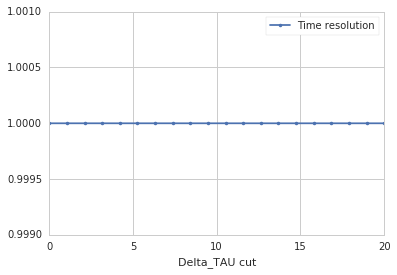

In [128]:
import random
import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("whitegrid", {"legend.frameon": True})

x, ys = unpack_cut_dict(cut_to_performance)
shift = 0.0

foms_to_plot = {}
#foms_to_plot["TaggingPower"] = r"Flavour Tagging"
foms_to_plot["TimeresPower"] = "Time resolution"
#foms_to_plot["EffSigSize"]   = "Effective signalsize"
#foms_to_plot["BsFOM"]        = "$X_i$-term"
#foms_to_plot["BdFOM_p"]      = "FOM ${}_{B^0_d}$"
#foms_to_plot["BdFOM"]        = "FOM"

#for parameter, values in ys.items():
for parameter in foms_to_plot:
    values=ys[parameter]
    #if "FOM" in parameter or "EffSig" in parameter or "s3_over_spb2" in parameter\
    #or "TaggingPower" in parameter or "TimeresPower" in parameter:
    if parameter in foms_to_plot:
        plt.errorbar(x,values+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter])
        plt.xlabel("Delta_TAU cut")
'''values_EffSigSize=ys['EffSigSize']
values_TimeresPower=ys['TimeresPower']
values_TaggingPower=ys['TaggingPower']
values_BdFOM_p=ys['BdFOM_p']
values_BdFOM=ys['BdFOM']


plt.errorbar(x,values_EffSigSize+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[0])
plt.errorbar(x,values_TimeresPower+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[1])
plt.errorbar(x,values_TaggingPower+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[2])
plt.errorbar(x,values_BdFOM_p+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[3])
plt.errorbar(x,values_BdFOM+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[4])
plt.xlabel("BDT Schnitt")'''
plt.gca().set_ylim(0.999,1.001)
plt.gca().set_xlim(0.0,20)
plt.legend(loc='best')
plt.savefig(subdir + '/FOMS.pdf')
plt.show()

In [126]:
print(ys['BdFOM'])

[ 1.          0.99977665  0.99908111  0.99839553  0.99448122  0.9938409
  0.99333178  0.99279199  0.99222191  0.99168396  0.99131499  0.99069133
  0.99014182  0.98965669  0.98923996  0.98882555  0.9883853   0.98783267
  0.98711509  0.98668843]
